In [52]:
import squidpy as sq
import scanpy as sc
import scipy as scp
import numpy as np 
import pandas as pd
import scvi
import seaborn as sns
import pyensembl as ensb
import matplotlib as plt
import liana as li

In [3]:
control = sc.read_h5ad('data/normalCellsabv55.h5ad')
sclc = sc.read_h5ad('data/sclcCells.h5ad')

In [4]:
def qualityControl(adata):
    '''
    Compute quality control metrics: label mitochondrial and ribosomal genes and run sc.calculate_qc_metrics
    '''
    adata.var['mitochondrial'] = adata.var.index.str.startswith('MT-')
    ribosomalGeneSet = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt" # filter out ribosomal genes too
    df_ribo = pd.read_table(ribosomalGeneSet, skiprows=2, header = None)
    adata.var[adata.var.index.isin(df_ribo[0].values)] 
    adata.var['ribosomal'] = adata.var.index.isin(df_ribo[0].values) 
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mitochondrial', 'ribosomal'], percent_top=None, log1p=False, inplace=True)
    sc.pp.filter_genes(adata, min_cells=3) # filter genes in a minimum of 3 cells
    sc.pp.filter_cells(adata, min_genes=200) # filter cells with a minimum of 200 genes
    return adata

def normalization(adata):
    '''
    Perform normalization to unify counts
    '''
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    adata.X.sum(axis = 1)
    adata.raw = adata

def ensemblIDfGene(adata,gene):
    '''
    ENSEMBL ID from gene
    '''
    obj = adata.var[adata.var.feature_name == gene]
    id = obj.index.tolist()[0]
    return id

def genefEnsemblID(adata,id):
    '''
    Gene from ENSEMBL ID
    '''
    obj = adata.var[adata.var.index == id]
    gene_name = obj.feature_name.tolist()[0]
    return gene_name


In [5]:
qualityControl(sclc) # AnnData object with n_obs × n_vars = 20577 × 21199
qualityControl(control) # AnnData object with n_obs × n_vars = 61516 × 25545

AnnData object with n_obs × n_vars = 61516 × 25545
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 't

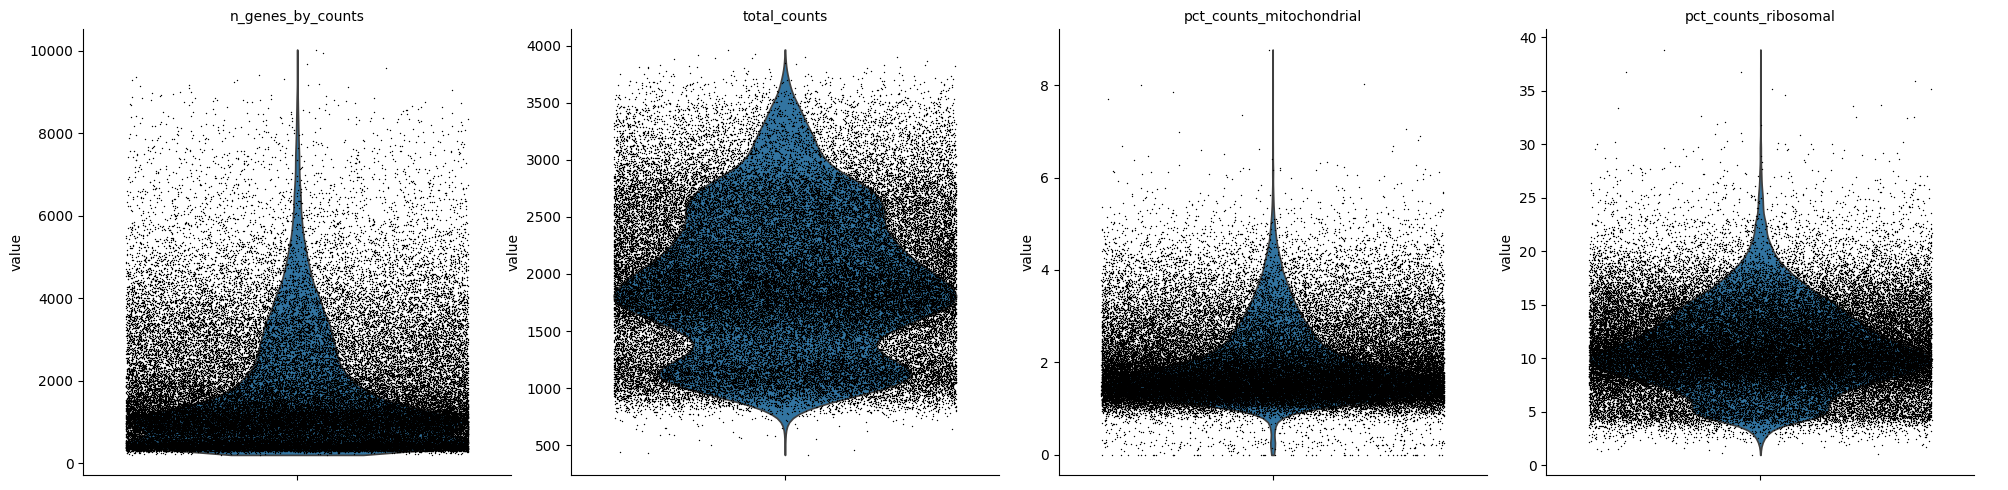

In [6]:
sc.pl.violin(control, [
    'n_genes_by_counts', 
    'total_counts', 
    'pct_counts_mitochondrial', 
    'pct_counts_ribosomal'
    ], 
    jitter=0.4, 
    multi_panel=True)

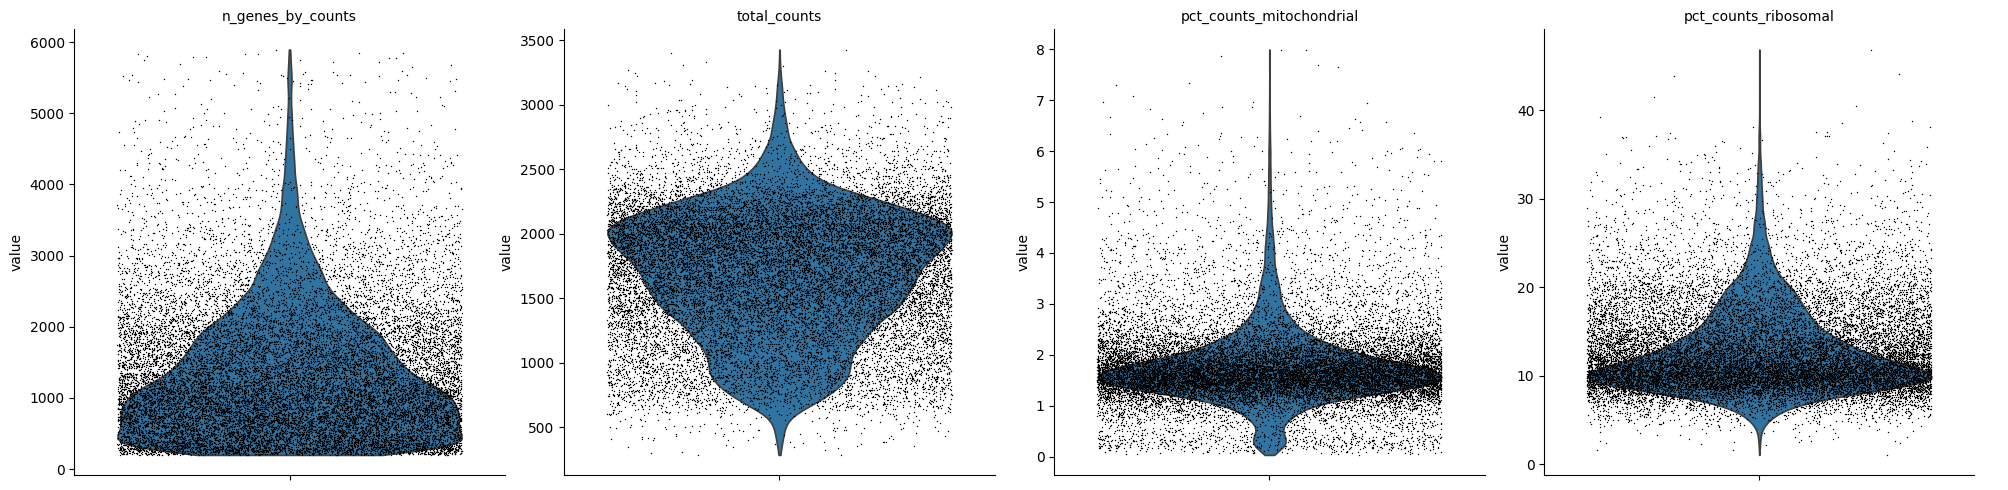

In [7]:
sc.pl.violin(sclc, [
    'n_genes_by_counts', 
    'total_counts', 
    'pct_counts_mitochondrial', 
    'pct_counts_ribosomal'
    ], 
    jitter=0.4, 
    multi_panel=True)

In [8]:
# Check metrics
print('Minimum genes in a cell in the SCLC condition data: ',sclc.obs.n_genes_by_counts.min())
print('Avg total count of a gene in the SCLC condition data: ',sclc.obs.total_counts.mean())
print('Minimum genes in a cell in the normal condition data: ',control.obs.n_genes_by_counts.min())
print('Avg total count of a gene in the normal condition data: ',control.obs.total_counts.mean())

Minimum genes in a cell in the SCLC condition data:  200
Avg total count of a gene in the SCLC condition data:  1680.0718
Minimum genes in a cell in the normal condition data:  204
Avg total count of a gene in the normal condition data:  1948.3007


In [9]:
upper_lim = np.quantile(sclc.obs.n_genes_by_counts.values, .98)
upper_lim
sclc = sclc[sclc.obs.n_genes_by_counts < upper_lim]
sclc = sclc[sclc.obs.pct_counts_mitochondrial < 20] # less than 20%
sclc = sclc[sclc.obs.pct_counts_ribosomal < 20] # less than 10%
sclc

View of AnnData object with n_obs × n_vars = 18383 × 21199
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmoni

In [10]:
upper_lim_ctrl = np.quantile(control.obs.n_genes_by_counts.values, .98)
upper_lim_ctrl
control = control[control.obs.n_genes_by_counts < upper_lim]
control = control[control.obs.pct_counts_mitochondrial < 20] # less than 20%
control = control[control.obs.pct_counts_ribosomal < 20] # less than 10%
control

View of AnnData object with n_obs × n_vars = 54276 × 25545
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmoni

In [11]:
# Normalization
normalization(control)
normalization(sclc)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


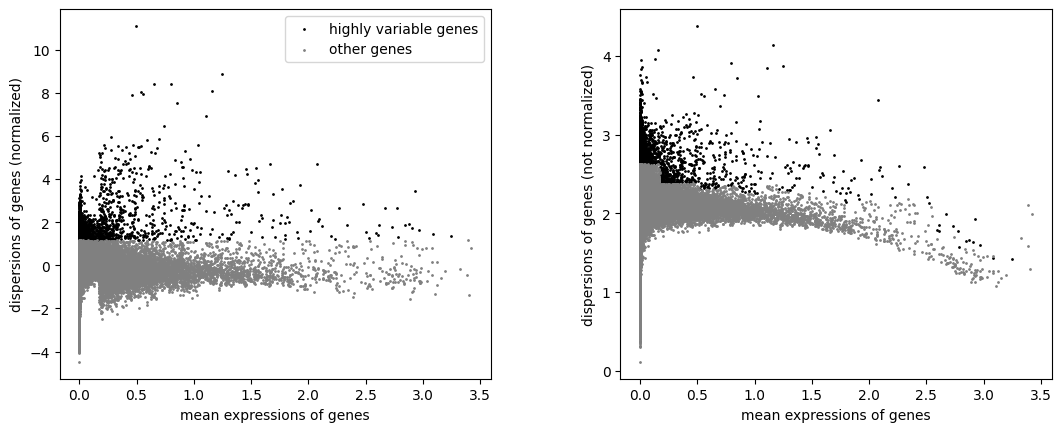

In [12]:
sc.pp.highly_variable_genes(sclc, n_top_genes = 2000)
sc.pl.highly_variable_genes(sclc)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


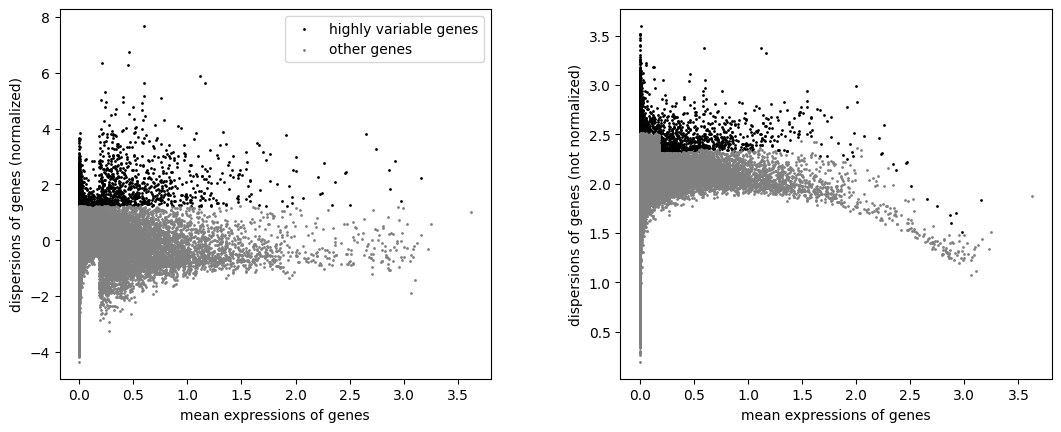

In [13]:
sc.pp.highly_variable_genes(control, n_top_genes = 2000)
sc.pl.highly_variable_genes(control)

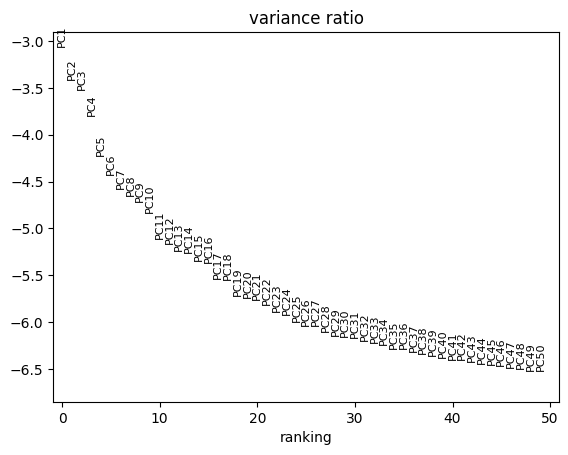

In [14]:
sclc = sclc[:, sclc.var.highly_variable]
sc.pp.regress_out(sclc, ['total_counts', 'pct_counts_mitochondrial', 'pct_counts_ribosomal'])
sc.pp.scale(sclc, max_value=10)
sc.tl.pca(sclc, svd_solver='arpack')
sc.pl.pca_variance_ratio(sclc, log=True, n_pcs = 50)

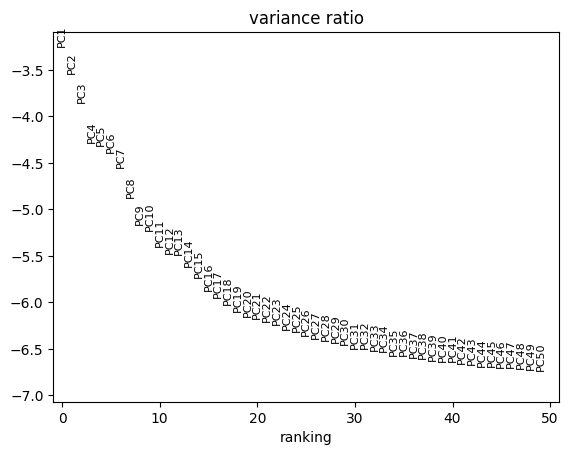

In [16]:
control = control[:, control.var.highly_variable]
sc.pp.regress_out(control, ['total_counts', 'pct_counts_mitochondrial', 'pct_counts_ribosomal'])
sc.pp.scale(control, max_value=10)
sc.tl.pca(control, svd_solver='arpack')
sc.pl.pca_variance_ratio(control, log=True, n_pcs = 50)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


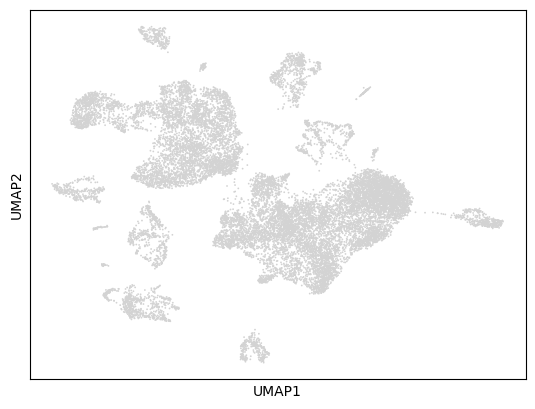

In [17]:
sc.pp.neighbors(sclc, n_pcs = 30)
sc.tl.umap(sclc)
sc.pl.umap(sclc)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


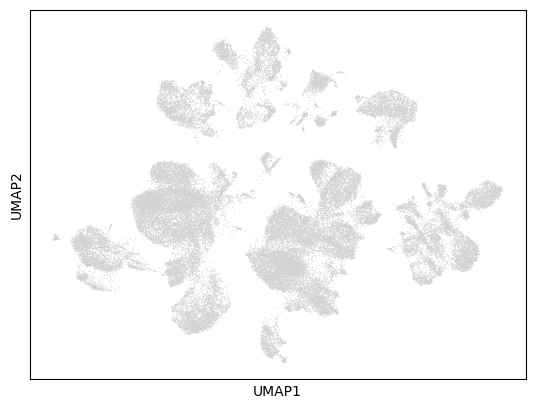

In [18]:
sc.pp.neighbors(control, n_pcs = 30)
sc.tl.umap(control)
sc.pl.umap(control)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


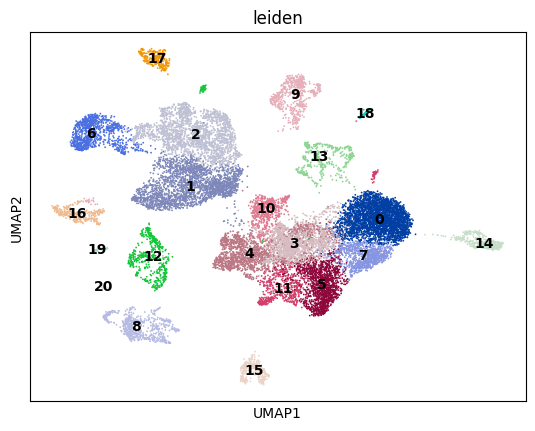

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


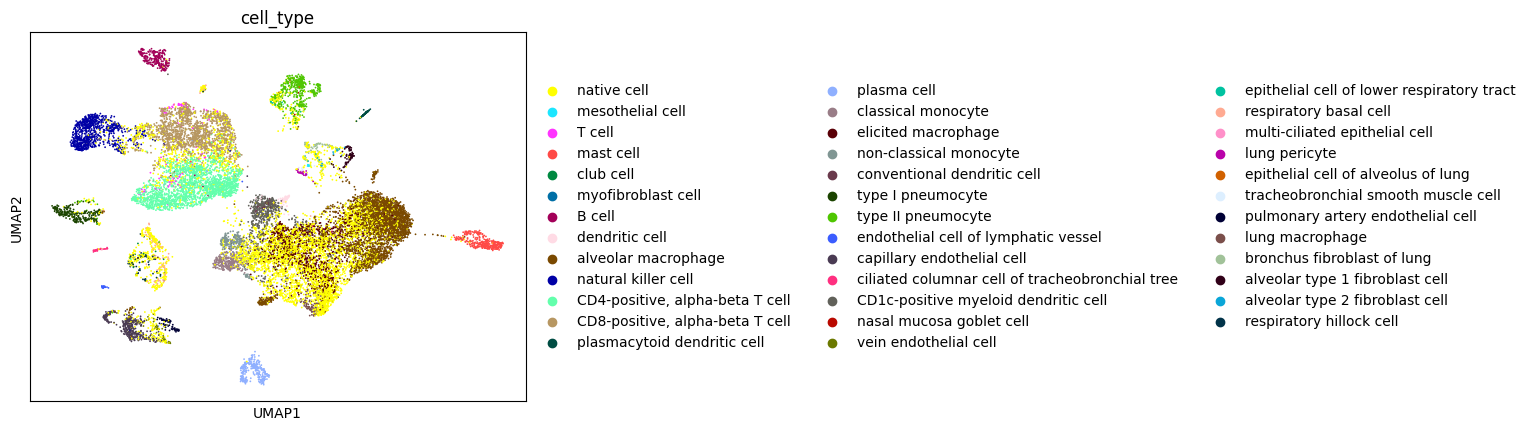

In [19]:
sc.tl.leiden(sclc, resolution = 0.5)

sc.pl.umap(sclc, color=['leiden'], legend_loc='on data')
sc.pl.umap(sclc, color=['cell_type'], legend_loc='right margin')

# sc.tl.paga(sclc, groups = ['leiden','cell_type'])

# cluster_labels = sclcCells.obs['leiden']
# cluster_labels

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


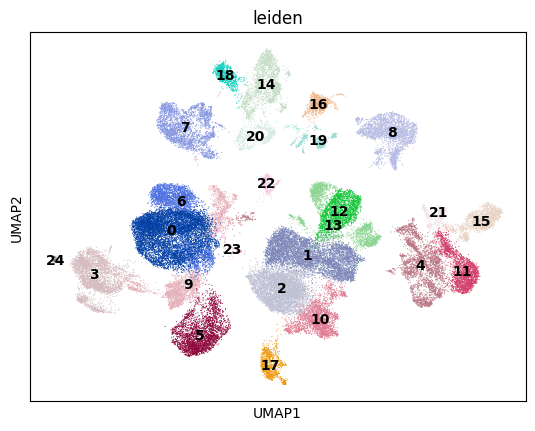

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


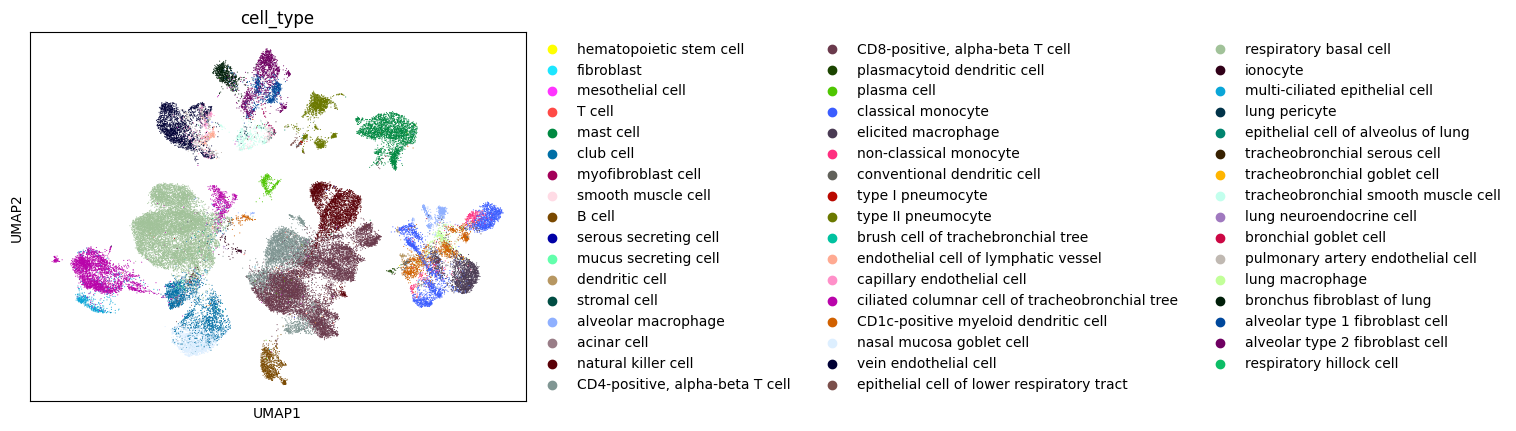

In [20]:
sc.tl.leiden(control, resolution = 0.5)

sc.pl.umap(control, color=['leiden'], legend_loc='on data')
sc.pl.umap(control, color=['cell_type'], legend_loc='right margin')

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


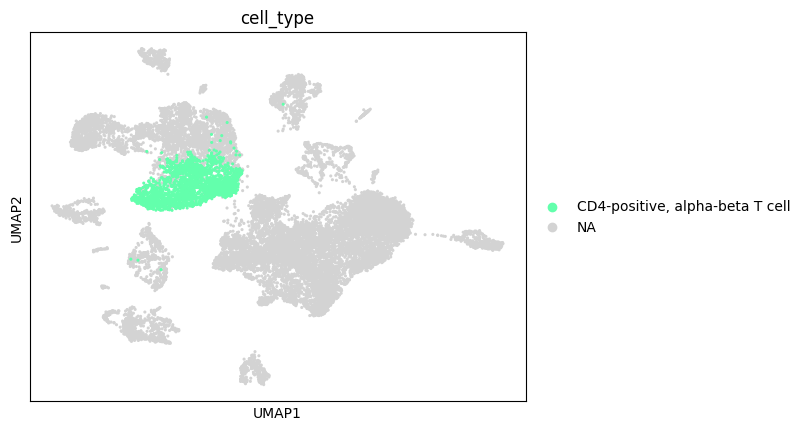

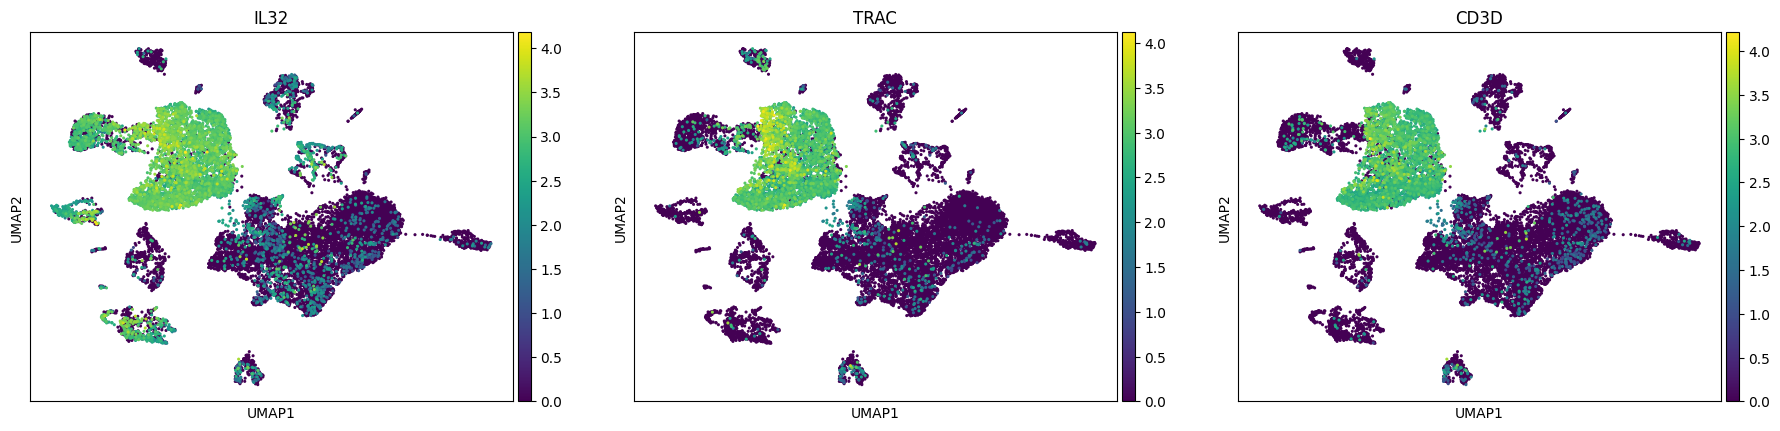

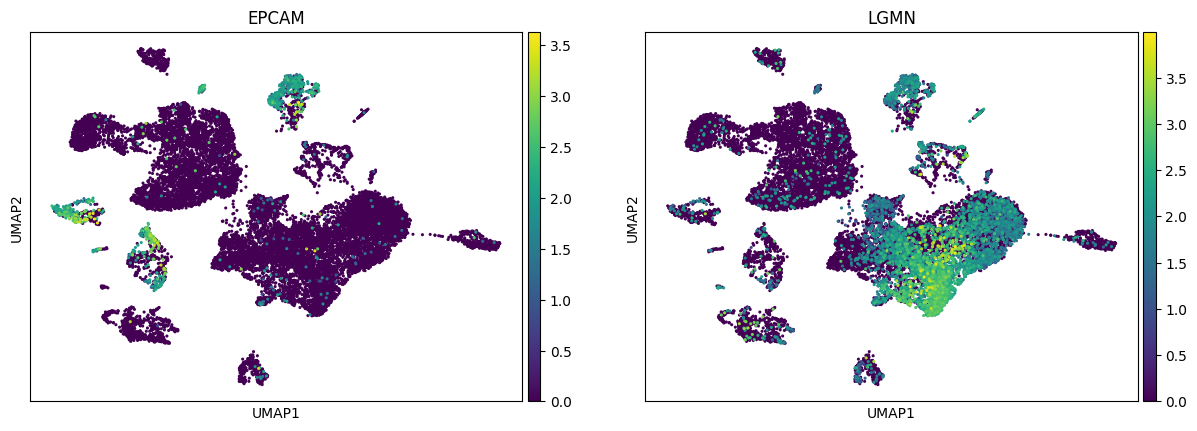

In [153]:

# sc.pl.umap(control, color=['leiden'], legend_loc='on data')
sc.pl.umap(sclc, color='cell_type', groups=['CD4-positive, alpha-beta T cell'], legend_loc='right margin', size=20)
sc.pl.umap(sclc, color=['IL32', 'TRAC', 'CD3D'], legend_loc='right margin', size=20)
sc.pl.umap(sclc, color=['EPCAM', 'LGMN'], legend_loc='right margin', size=20)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


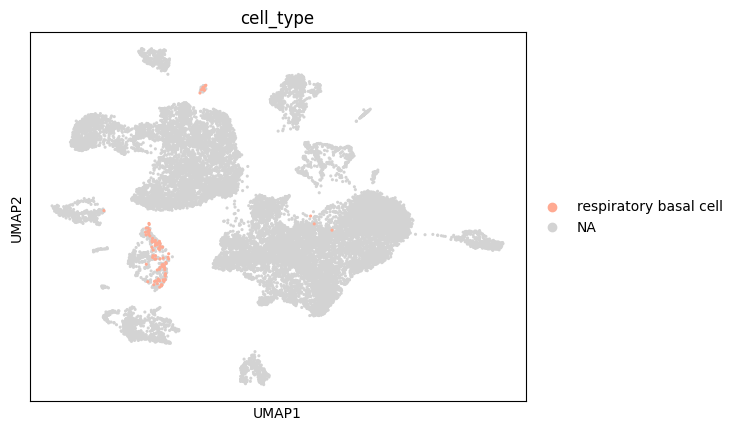

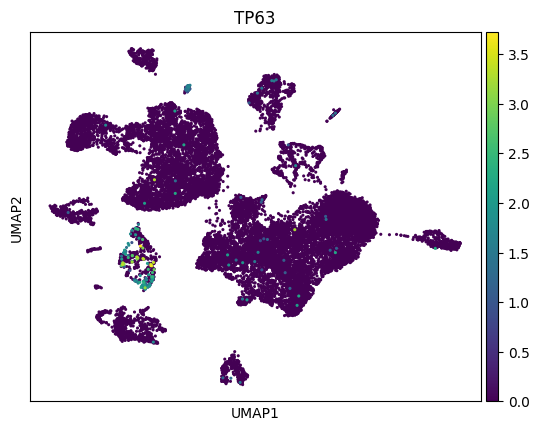

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


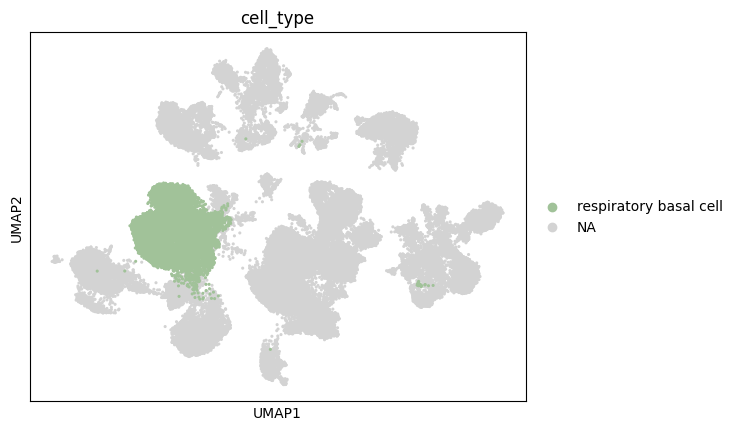

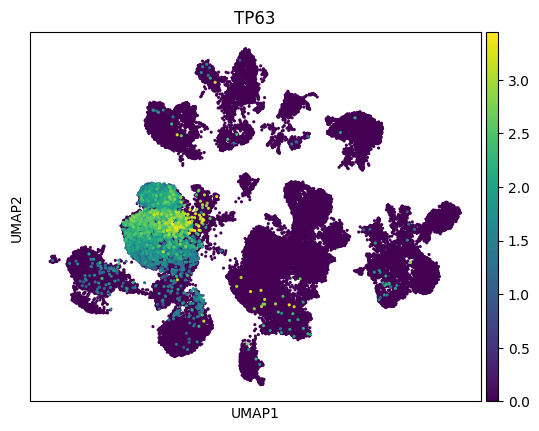

In [159]:
sc.pl.umap(sclc, color='cell_type', groups=['respiratory basal cell'], legend_loc='right margin', size=20)
sc.pl.umap(sclc, color=['TP63'], legend_loc='right margin', size=20)
sc.pl.umap(control, color='cell_type', groups=['respiratory basal cell'], legend_loc='right margin', size=20)
sc.pl.umap(control, color=['TP63'], legend_loc='right margin', size=20)
# sc.pl.umap(control, color=['CXCR4', 'BTG1', 'IL7R'], legend_loc='right margin', size=20)

In [ ]:
sc.pl.umap(sclc, color='cell_type', groups=['respiratory basal cell'], legend_loc='right margin', size=20)
sc.pl.umap(sclc, color=['TP63'], legend_loc='right margin', size=20)
sc.pl.umap(control, color='cell_type', groups=['respiratory basal cell'], legend_loc='right margin', size=20)
sc.pl.umap(control, color=['TP63'], legend_loc='right margin', size=20)

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


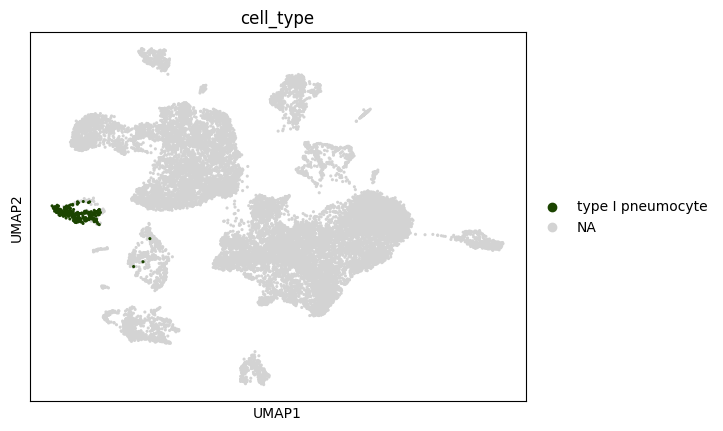

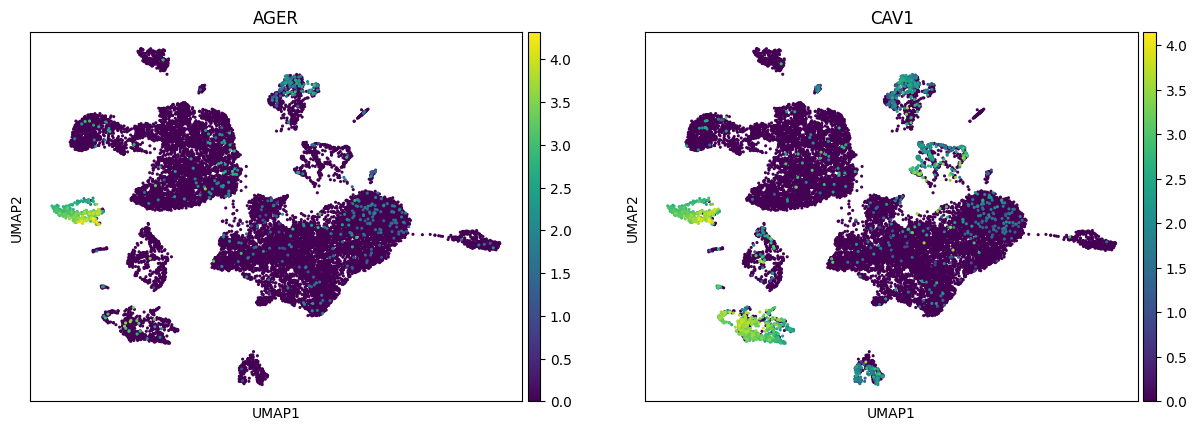

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


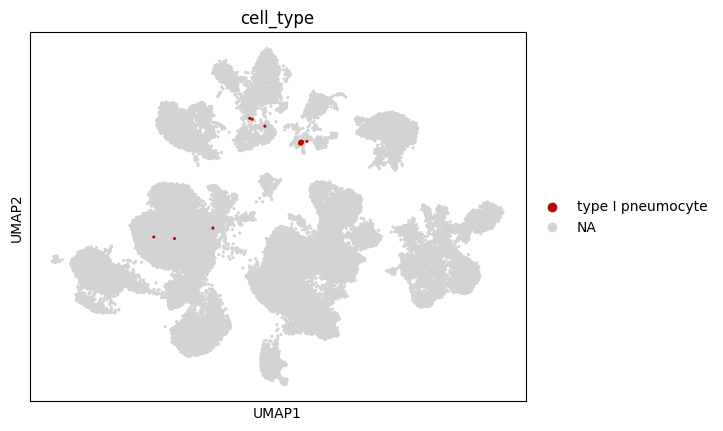

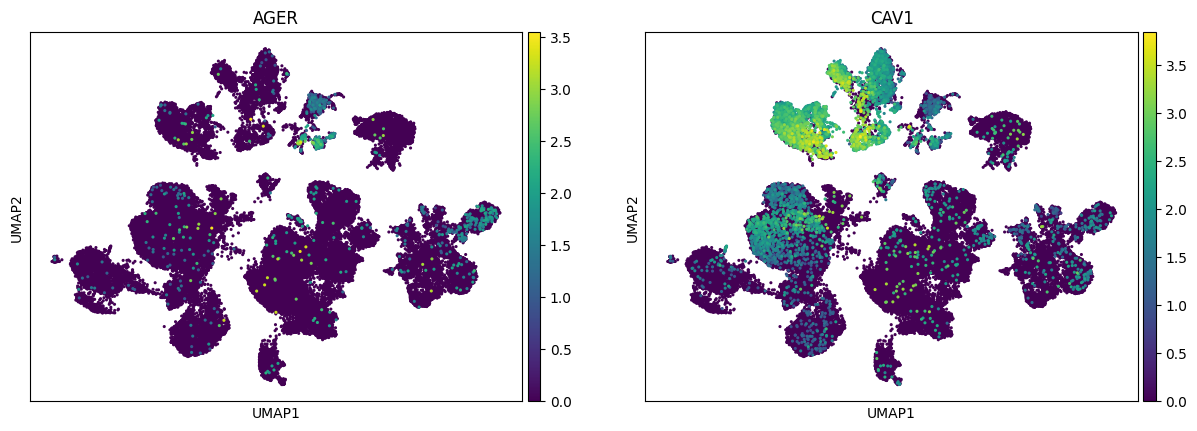

In [190]:
sc.pl.umap(sclc, color='cell_type', groups=['type I pneumocyte'], legend_loc='right margin', size=20)
sc.pl.umap(sclc, color=['AGER', 'CAV1'], legend_loc='right margin', size=20)
sc.pl.umap(control, color='cell_type', groups=['type I pneumocyte'], legend_loc='right margin', size=20)
sc.pl.umap(control, color=['AGER', 'CAV1'], legend_loc='right margin', size=20)

In [23]:
myofibroblast = sclc.obs.cell_type == 'myofibroblast cell'
multiciliated = sclc.obs.cell_type == 'multi-ciliated epithelial cell'
sclc = sclc[~myofibroblast, :]
sclc = sclc[~multiciliated, :]
sclc

View of AnnData object with n_obs × n_vars = 18381 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmoniz

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) i

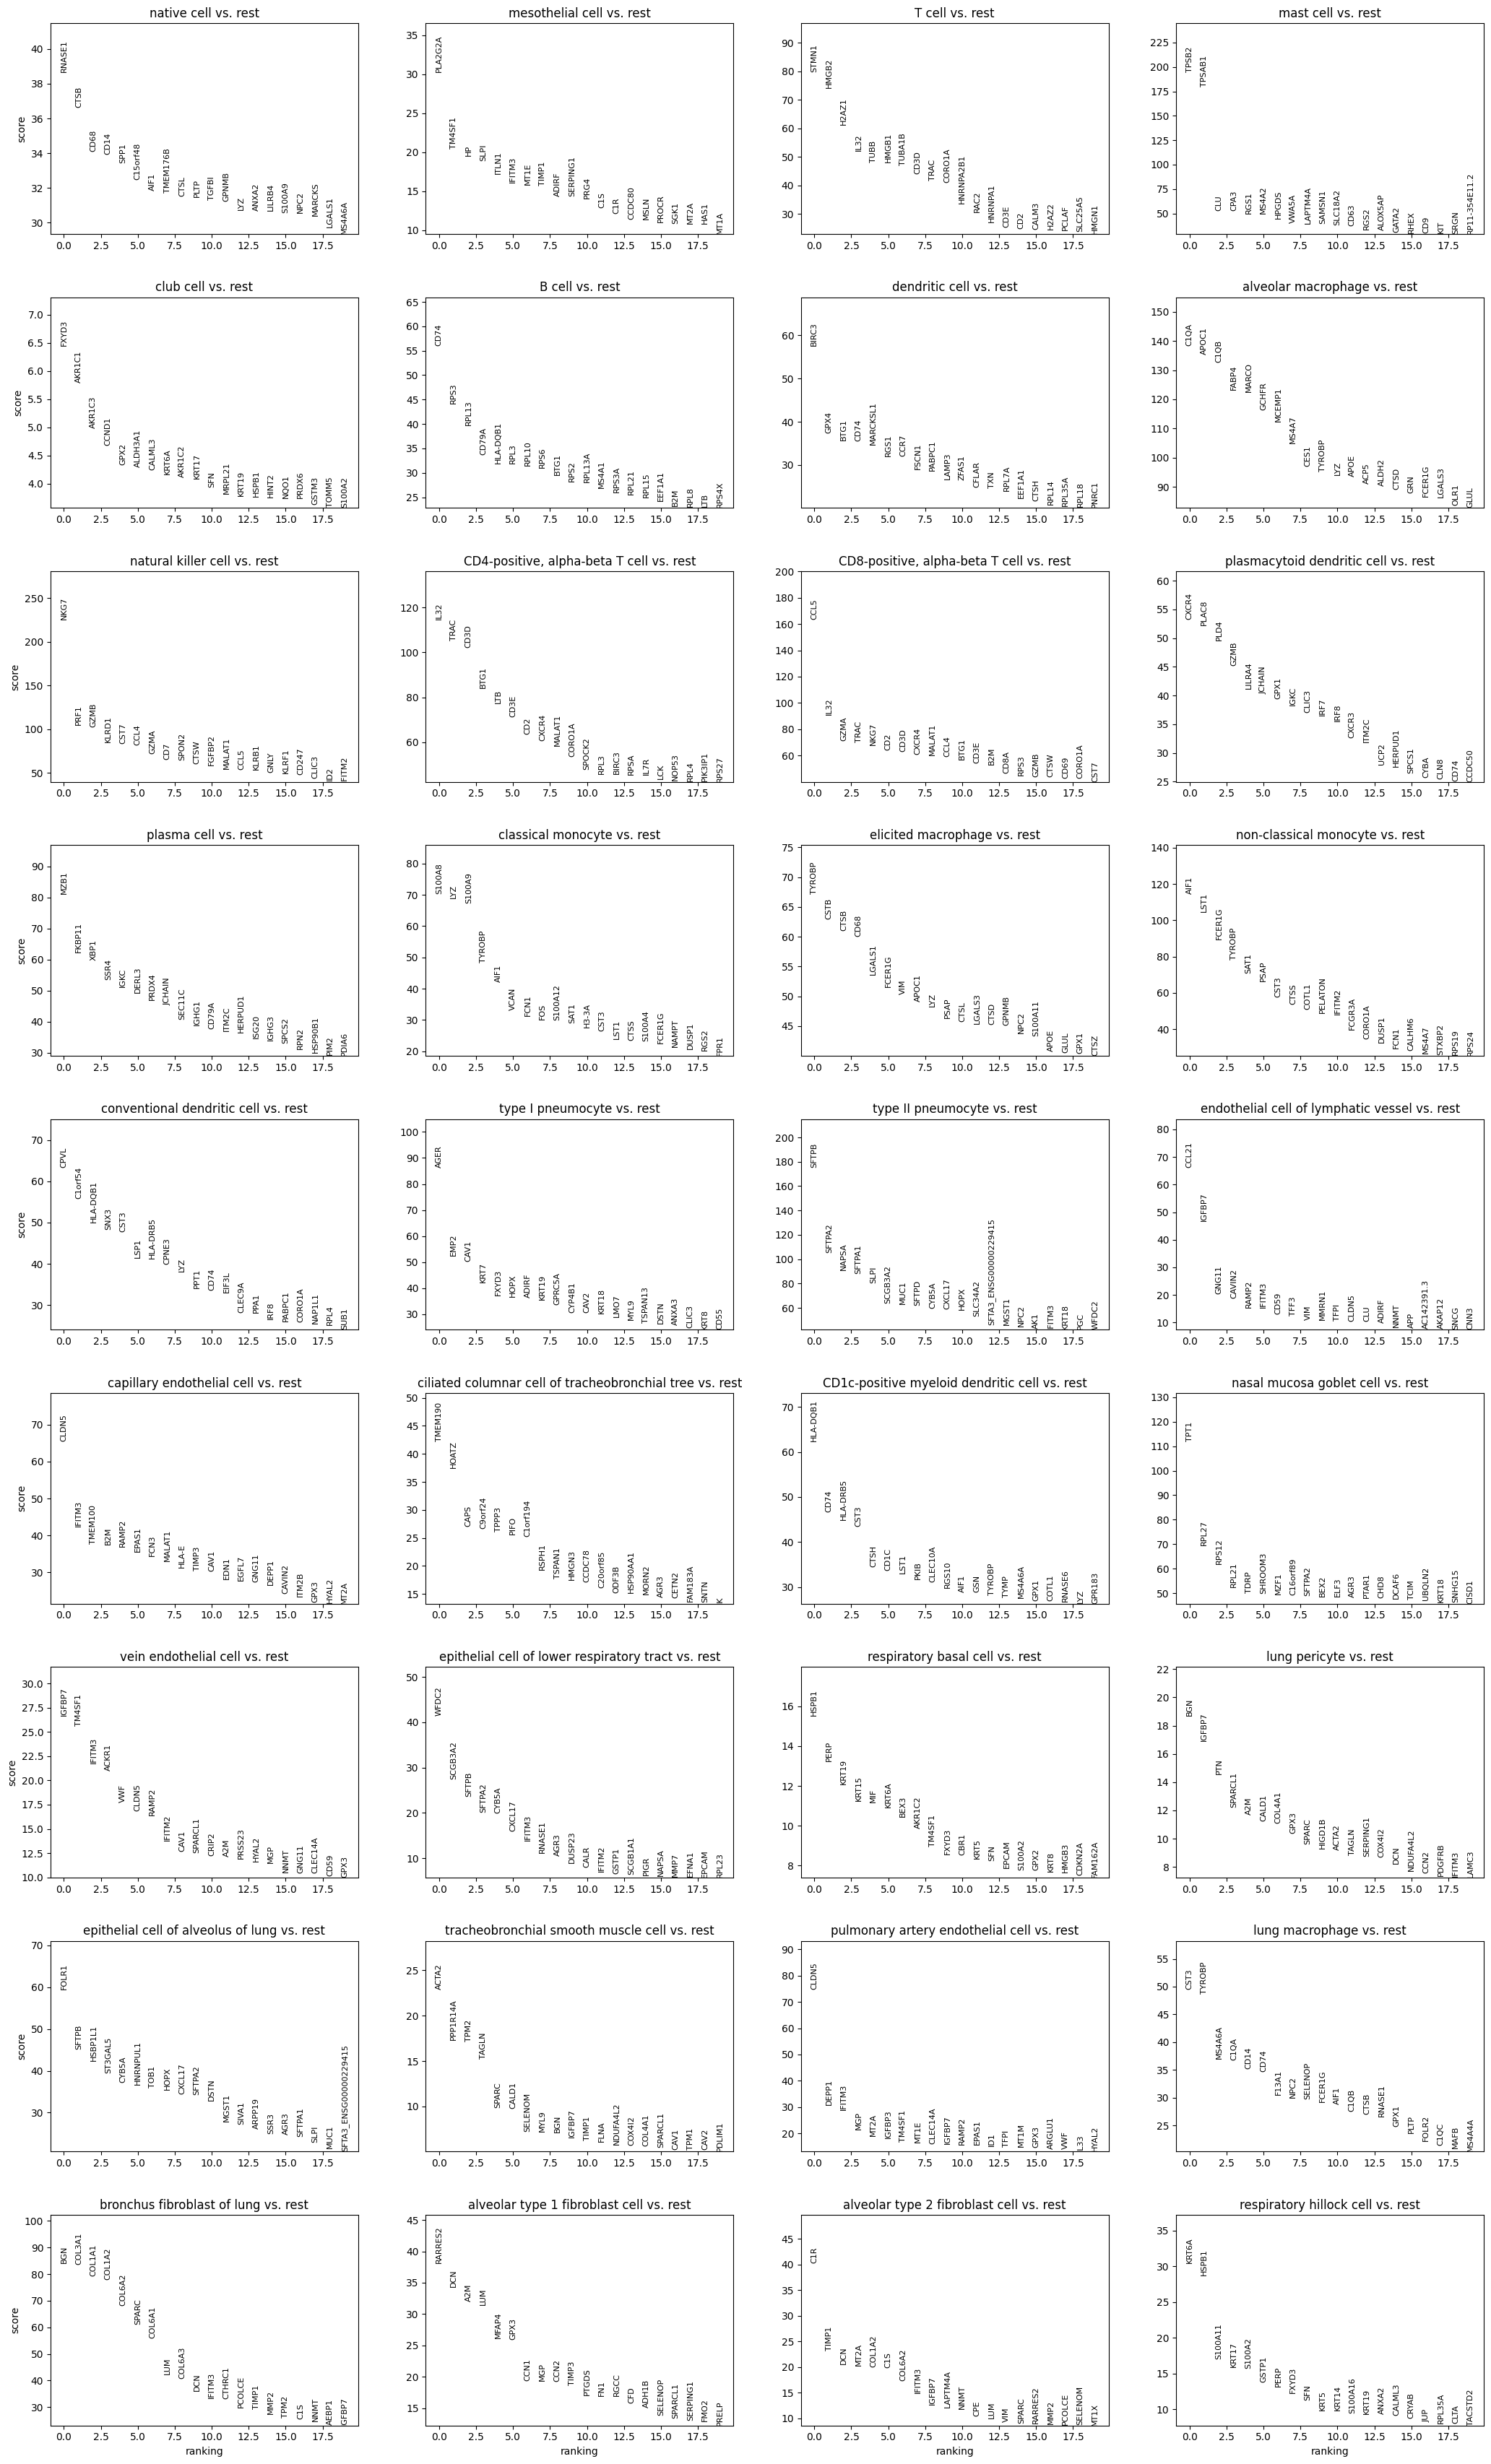

In [24]:
sc.tl.rank_genes_groups(sclc, 'cell_type')
sc.pl.rank_genes_groups(sclc, n_genes=20, sharey=False)

In [132]:

# Get the results of the gene ranking analysis
result_table = pd.DataFrame(sclc.uns['rank_genes_groups']['names']).head(5)

result_table.T

0         1         2  \
native cell                                        RNASE1      CTSB      CD68   
mesothelial cell                                  PLA2G2A    TM4SF1        HP   
T cell                                              STMN1     HMGB2     H2AZ1   
mast cell                                           TPSB2    TPSAB1       CLU   
club cell                                           FXYD3    AKR1C1    AKR1C3   
B cell                                               CD74      RPS3     RPL13   
dendritic cell                                      BIRC3      GPX4      BTG1   
alveolar macrophage                                  C1QA     APOC1      C1QB   
natural killer cell                                  NKG7      PRF1      GZMB   
CD4-positive, alpha-beta T cell                      IL32      TRAC      CD3D   
CD8-positive, alpha-beta T cell                      CCL5      IL32      GZMA   
plasmacytoid dendritic cell                         CXCR4     PLAC8      PLD4   
plasma cell                                          MZB1    FKBP11      XBP1   
classical monocyte                                 S100A8       LYZ    S100A9   
elicited macrophage                                TYROBP      CSTB      CTSB   
non-classical monocyte                               AIF1      LST1    FCER1G   
conventional dendritic cell                          CPVL   C1orf54  HLA-DQB1   
type I pneumocyte                                    AGER      EMP2      CAV1   
type II pneumocyte                                  SFTPB    SFTPA2     NAPSA   
endothelial cell of lymphatic vessel                CCL21    IGFBP7     GNG11   
capillary endothelial cell                          CLDN5    IFITM3   TMEM100   
ciliated columnar cell of tracheobronchial tree   TMEM190     HOATZ      CAPS   
CD1c-positive myeloid dendritic cell             HLA-DQB1      CD74  HLA-DRB5   
nasal mucosa goblet cell                             TPT1     RPL27     RPS12   
vein endothelial cell                              IGFBP7    TM4SF1    IFITM3   
epithelial cell of lower respiratory tract          WFDC2   SCGB3A2     SFTPB   
respiratory basal cell                              HSPB1      PERP     KRT19   
lung pericyte                                         BGN    IGFBP7       PTN   
epithelial cell of alveolus of lung                 FOLR1     SFTPB   HSBP1L1   
tracheobronchial smooth muscle cell                 ACTA2  PPP1R14A      TPM2   
pulmonary artery endothelial cell                   CLDN5     DEPP1    IFITM3   
lung macrophage                                      CST3    TYROBP    MS4A6A   
bronchus fibroblast of lung                           BGN    COL3A1    COL1A1   
alveolar type 1 fibroblast cell                   RARRES2       DCN       A2M   
alveolar type 2 fibroblast cell                       C1R     TIMP1       DCN   
respiratory hillock cell                            KRT6A     HSPB1   S100A11   

                                                       3         4  
native cell                                         CD14      SPP1  
mesothelial cell                                    SLPI     ITLN1  
T cell                                              IL32      TUBB  
mast cell                                           CPA3      RGS1  
club cell                                          CCND1      GPX2  
B cell                                             CD79A  HLA-DQB1  
dendritic cell                                      CD74  MARCKSL1  
alveolar macrophage                                FABP4     MARCO  
natural killer cell                                KLRD1      CST7  
CD4-positive, alpha-beta T cell                     BTG1       LTB  
CD8-positive, alpha-beta T cell                     TRAC      NKG7  
plasmacytoid dendritic cell                         GZMB    LILRA4  
plasma cell                                         SSR4      IGKC  
classical monocyte                                TYROBP      AIF1  
elicited macrophage    

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:411: Perf

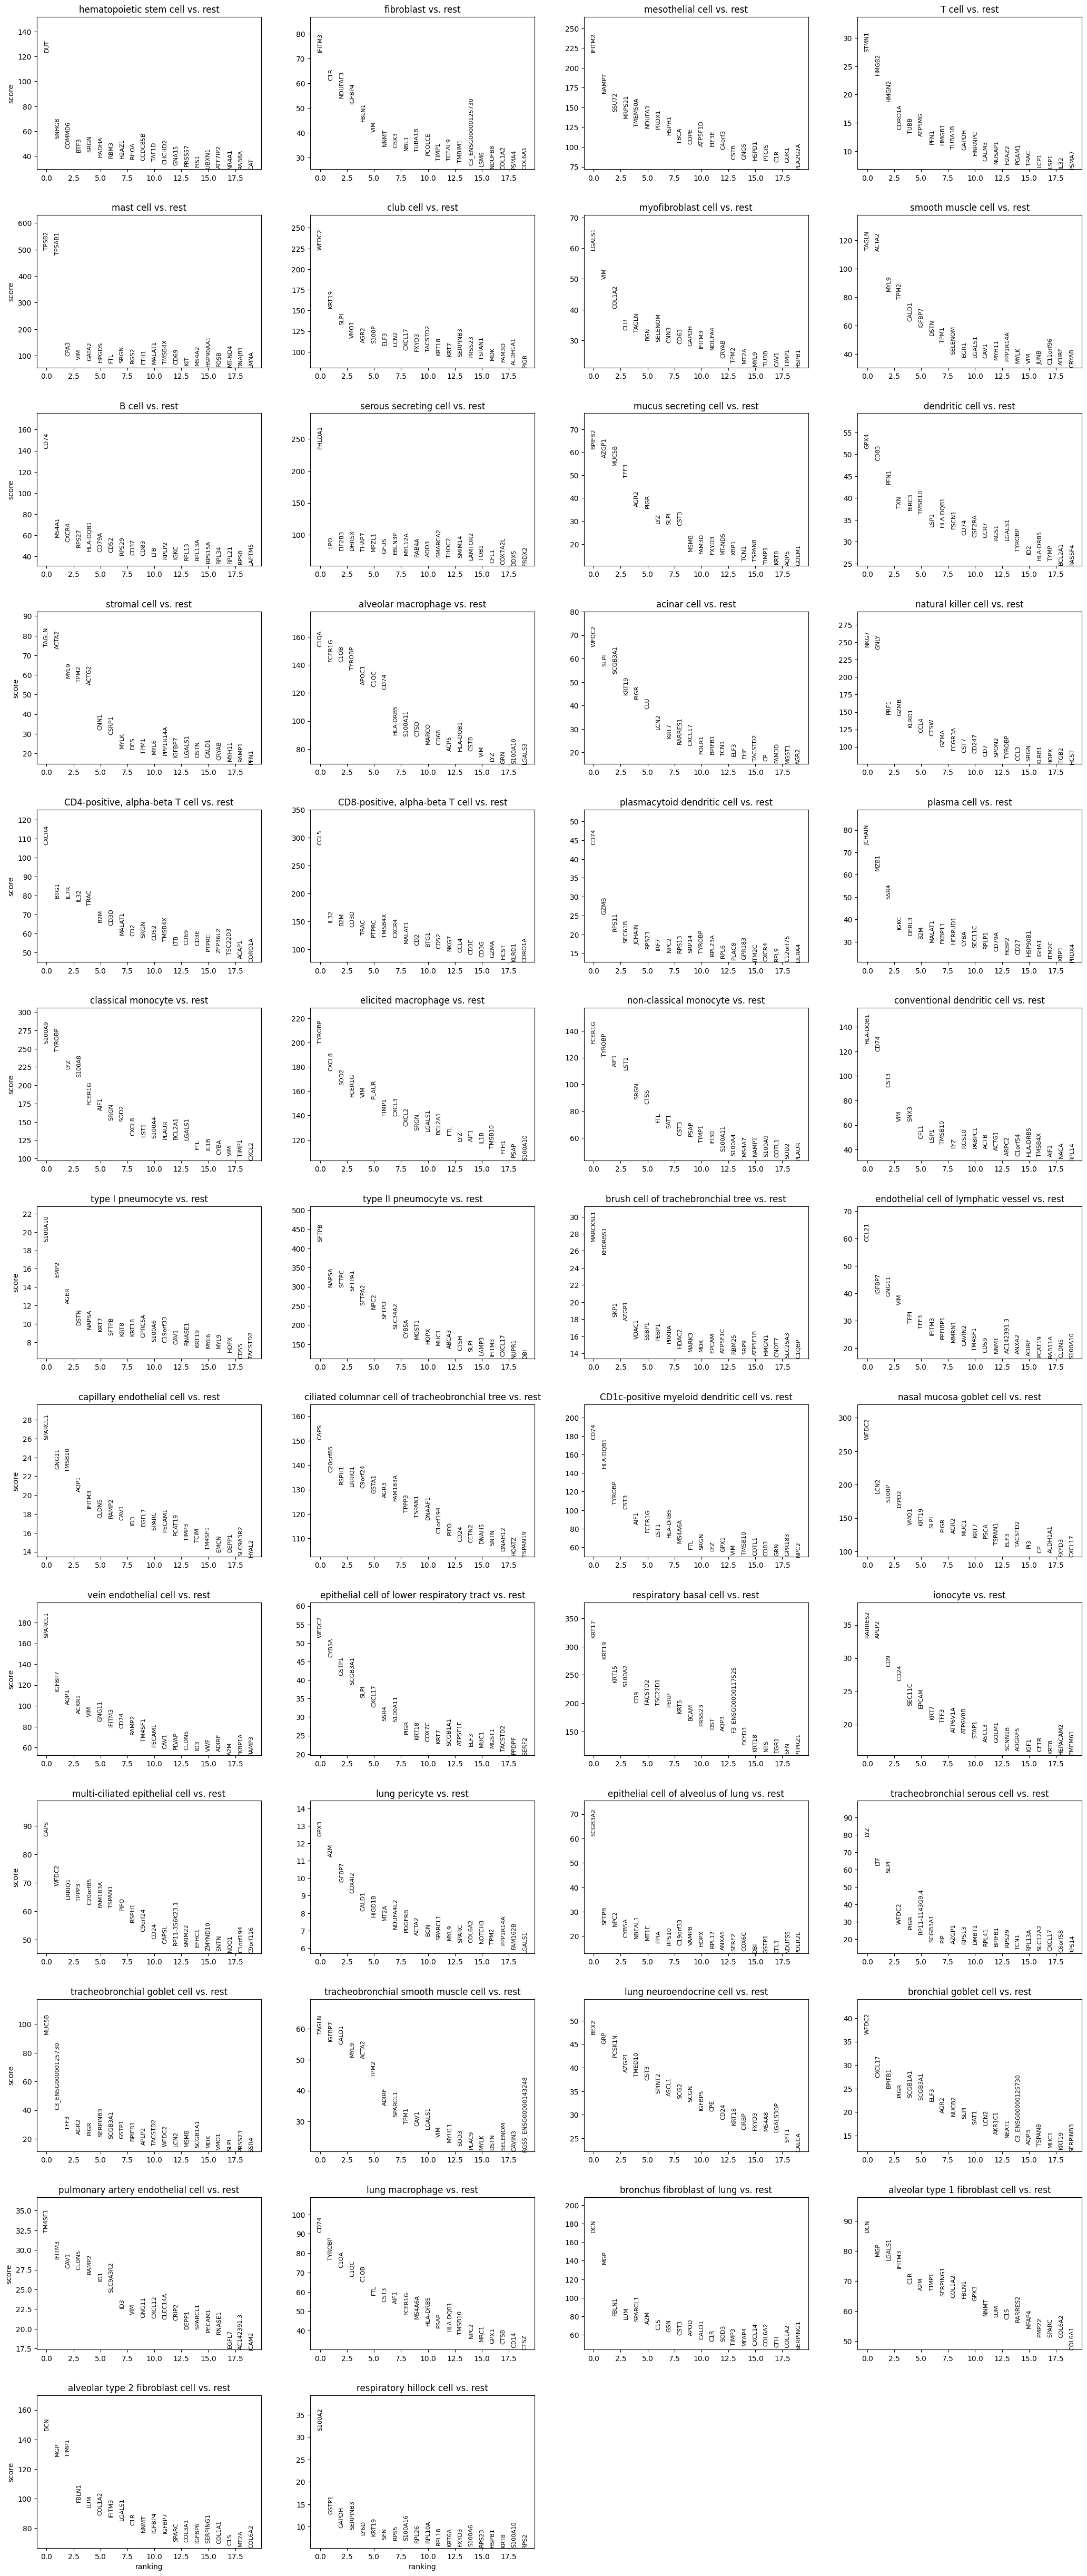

In [25]:
sc.tl.rank_genes_groups(control, 'cell_type')
sc.pl.rank_genes_groups(control, n_genes=20, sharey=False)

In [135]:
result_table = pd.DataFrame(control.uns['rank_genes_groups']['names']).head(5)

result_table.T


0                   1  \
hematopoietic stem cell                               DUT               SNHG8   
fibroblast                                         IFITM3                 C1R   
mesothelial cell                                   IFITM2               NAMPT   
T cell                                              STMN1               HMGB2   
mast cell                                           TPSB2              TPSAB1   
club cell                                           WFDC2               KRT19   
myofibroblast cell                                 LGALS1                 VIM   
smooth muscle cell                                  TAGLN               ACTA2   
B cell                                               CD74               MS4A1   
serous secreting cell                              PHLDA1                 LPO   
mucus secreting cell                               BPIFB2               AZGP1   
dendritic cell                                       GPX4                CD83   
stromal cell                                        TAGLN               ACTA2   
alveolar macrophage                                  C1QA              FCER1G   
acinar cell                                         WFDC2                SLPI   
natural killer cell                                  NKG7                GNLY   
CD4-positive, alpha-beta T cell                     CXCR4                BTG1   
CD8-positive, alpha-beta T cell                      CCL5                IL32   
plasmacytoid dendritic cell                          CD74                GZMB   
plasma cell                                        JCHAIN                MZB1   
classical monocyte                                 S100A9              TYROBP   
elicited macrophage                                TYROBP               CXCL8   
non-classical monocyte                             FCER1G              TYROBP   
conventional dendritic cell                      HLA-DQB1                CD74   
type I pneumocyte                                 S100A10                EMP2   
type II pneumocyte                                  SFTPB               NAPSA   
brush cell of trachebronchial tree               MARCKSL1             KHDRBS1   
endothelial cell of lymphatic vessel                CCL21              IGFBP7   
capillary endothelial cell                        SPARCL1               GNG11   
ciliated columnar cell of tracheobronchial tree      CAPS            C20orf85   
CD1c-positive myeloid dendritic cell                 CD74            HLA-DQB1   
nasal mucosa goblet cell                            WFDC2                LCN2   
vein endothelial cell                             SPARCL1              IGFBP7   
epithelial cell of lower respiratory tract          WFDC2               CYB5A   
respiratory basal cell                              KRT17               KRT19   
ionocyte                                          RARRES2               APLP2   
multi-ciliated epithelial cell                       CAPS               WFDC2   
lung pericyte                                        GPX3                 A2M   
epithelial cell of alveolus of lung               SCGB3A2               SFTPB   
tracheobronchial serous cell                          LYZ                 LTF   
tracheobronchial goblet cell                        MUC5B  C3_ENSG00000125730   
tracheobronchial smooth muscle cell                 TAGLN              IGFBP7   
lung neuroendocrine cell                             BEX2                 GRP   
bronchial goblet cell                               WFDC2              CXCL17   
pulmonary artery endothelial cell                  TM4SF1              IFITM3   
lung macrophage                                      CD74              TYROBP   
bronchus fibroblast of lung                           DCN                 MGP   
alveolar type 1 fibroblast cell                       DCN                 MGP   
alveolar type 2 fibroblast cell                       DCN                 MGP   
respir

In [26]:
def markers(adata):
    '''
    Get marker genes from rank_genes_groups()
    '''
    markers = sc.get.rank_genes_groups_df(adata, None)
    markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 1)]
    return markers

In [27]:
sclcMarkers = markers(sclc)
sclcMarkers.to_csv('results/sclcMarkers.csv')
controlMarkers = markers(control)
controlMarkers.to_csv('results/controlMarkers.csv')

/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


In [28]:
sclcMarkers

group   names     scores  logfoldchanges  \
0                    native cell  RNASE1  38.676357        1.932592   
1                    native cell    CTSB  36.607067        1.275711   
2                    native cell    CD68  34.104832        1.314612   
3                    native cell    CD14  33.905663        1.617134   
4                    native cell    SPP1  33.428078        1.870765   
...                          ...     ...        ...             ...   
742432  respiratory hillock cell   VPS25   2.306676        1.333766   
742433  respiratory hillock cell   SENP5   2.304311        1.957749   
742434  respiratory hillock cell    CDK4   2.303652        1.208497   
742437  respiratory hillock cell  TIMM8A   2.297578        2.600601   
742438  respiratory hillock cell    TNS4   2.294225        5.311518   

                pvals      pvals_adj  
0       4.225046e-302  8.956675e-298  
1       7.102813e-277  7.528627e-273  
2       4.680133e-242  3.307138e-238  
3       5.814181e-237  3.081370e-233  
4       2.347294e-229  9.952057e-226  
...               ...            ...  
742432   2.485431e-02   4.828064e-02  
742433   2.500051e-02   4.853794e-02  
742434   2.503381e-02   4.859814e-02  
742437   2.541156e-02   4.925989e-02  
742438   2.561954e-02   4.963977e-02  

[30203 rows x 6 columns]

In [29]:
controlMarkers


group      names      scores  logfoldchanges  \
0         hematopoietic stem cell        DUT  123.528229        3.296336   
1         hematopoietic stem cell      SNHG8   54.172615        2.547828   
2         hematopoietic stem cell     COMMD6   46.221798        1.633149   
3         hematopoietic stem cell       BTF3   43.502277        1.382027   
4         hematopoietic stem cell       SRGN   43.147533        2.126544   
...                           ...        ...         ...             ...   
1251795  respiratory hillock cell    TMEM258    2.385739        1.435117   
1251796  respiratory hillock cell     FGFBP1    2.380333        3.928392   
1251797  respiratory hillock cell     CHCHD2    2.373320        1.106016   
1251799  respiratory hillock cell     PHLDA3    2.339743        2.774838   
1251800  respiratory hillock cell  UNC5B-AS1    2.336436        3.742538   

            pvals  pvals_adj  
0        0.000012   0.000019  
1        0.000215   0.000323  
2        0.000216   0.000324  
3        0.000255   0.000381  
4        0.000303   0.000451  
...           ...        ...  
1251795  0.031716   0.045686  
1251796  0.032052   0.046141  
1251797  0.032476   0.046711  
1251799  0.034631   0.049622  
1251800  0.034851   0.049917  

[73314 rows x 6 columns]

In [31]:

# cellTypeDict = {
#     '0':'alveolar macrophage',    
#     '1':'lung macrophage',
#     '2':'', # native
#     '3':'CD1c+ myeloid dentritic cell',
#     '4':'capillary endothelial',
#     '5':'T-cell cluster', # CD4+, CD8+ T-cells
#     '6':'vein endothelial cell',
#     '7':'type 1 pneumocyte',
#     '8':'native',
#     '9':'elicited macrophage',
#     '10':'fibroblast', # alveolar type 1 fibroblast, bronchous fibroblast, alveolar type 2 fibroblast
#     '11':'type 2 pneumocyte',
#     '12':'natural killer cell',
#     '13':'NK Cells',
#     '14':'', # native
#     '15':'mast cell',
#     '16':'plasma cell',

# }

In [32]:
sc.pp.neighbors(sclc, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(sclc)


/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


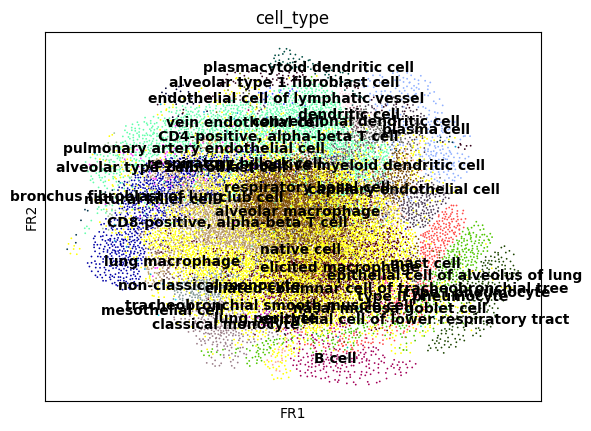

In [33]:
sc.pl.draw_graph(sclc, color="cell_type", legend_loc="on data")


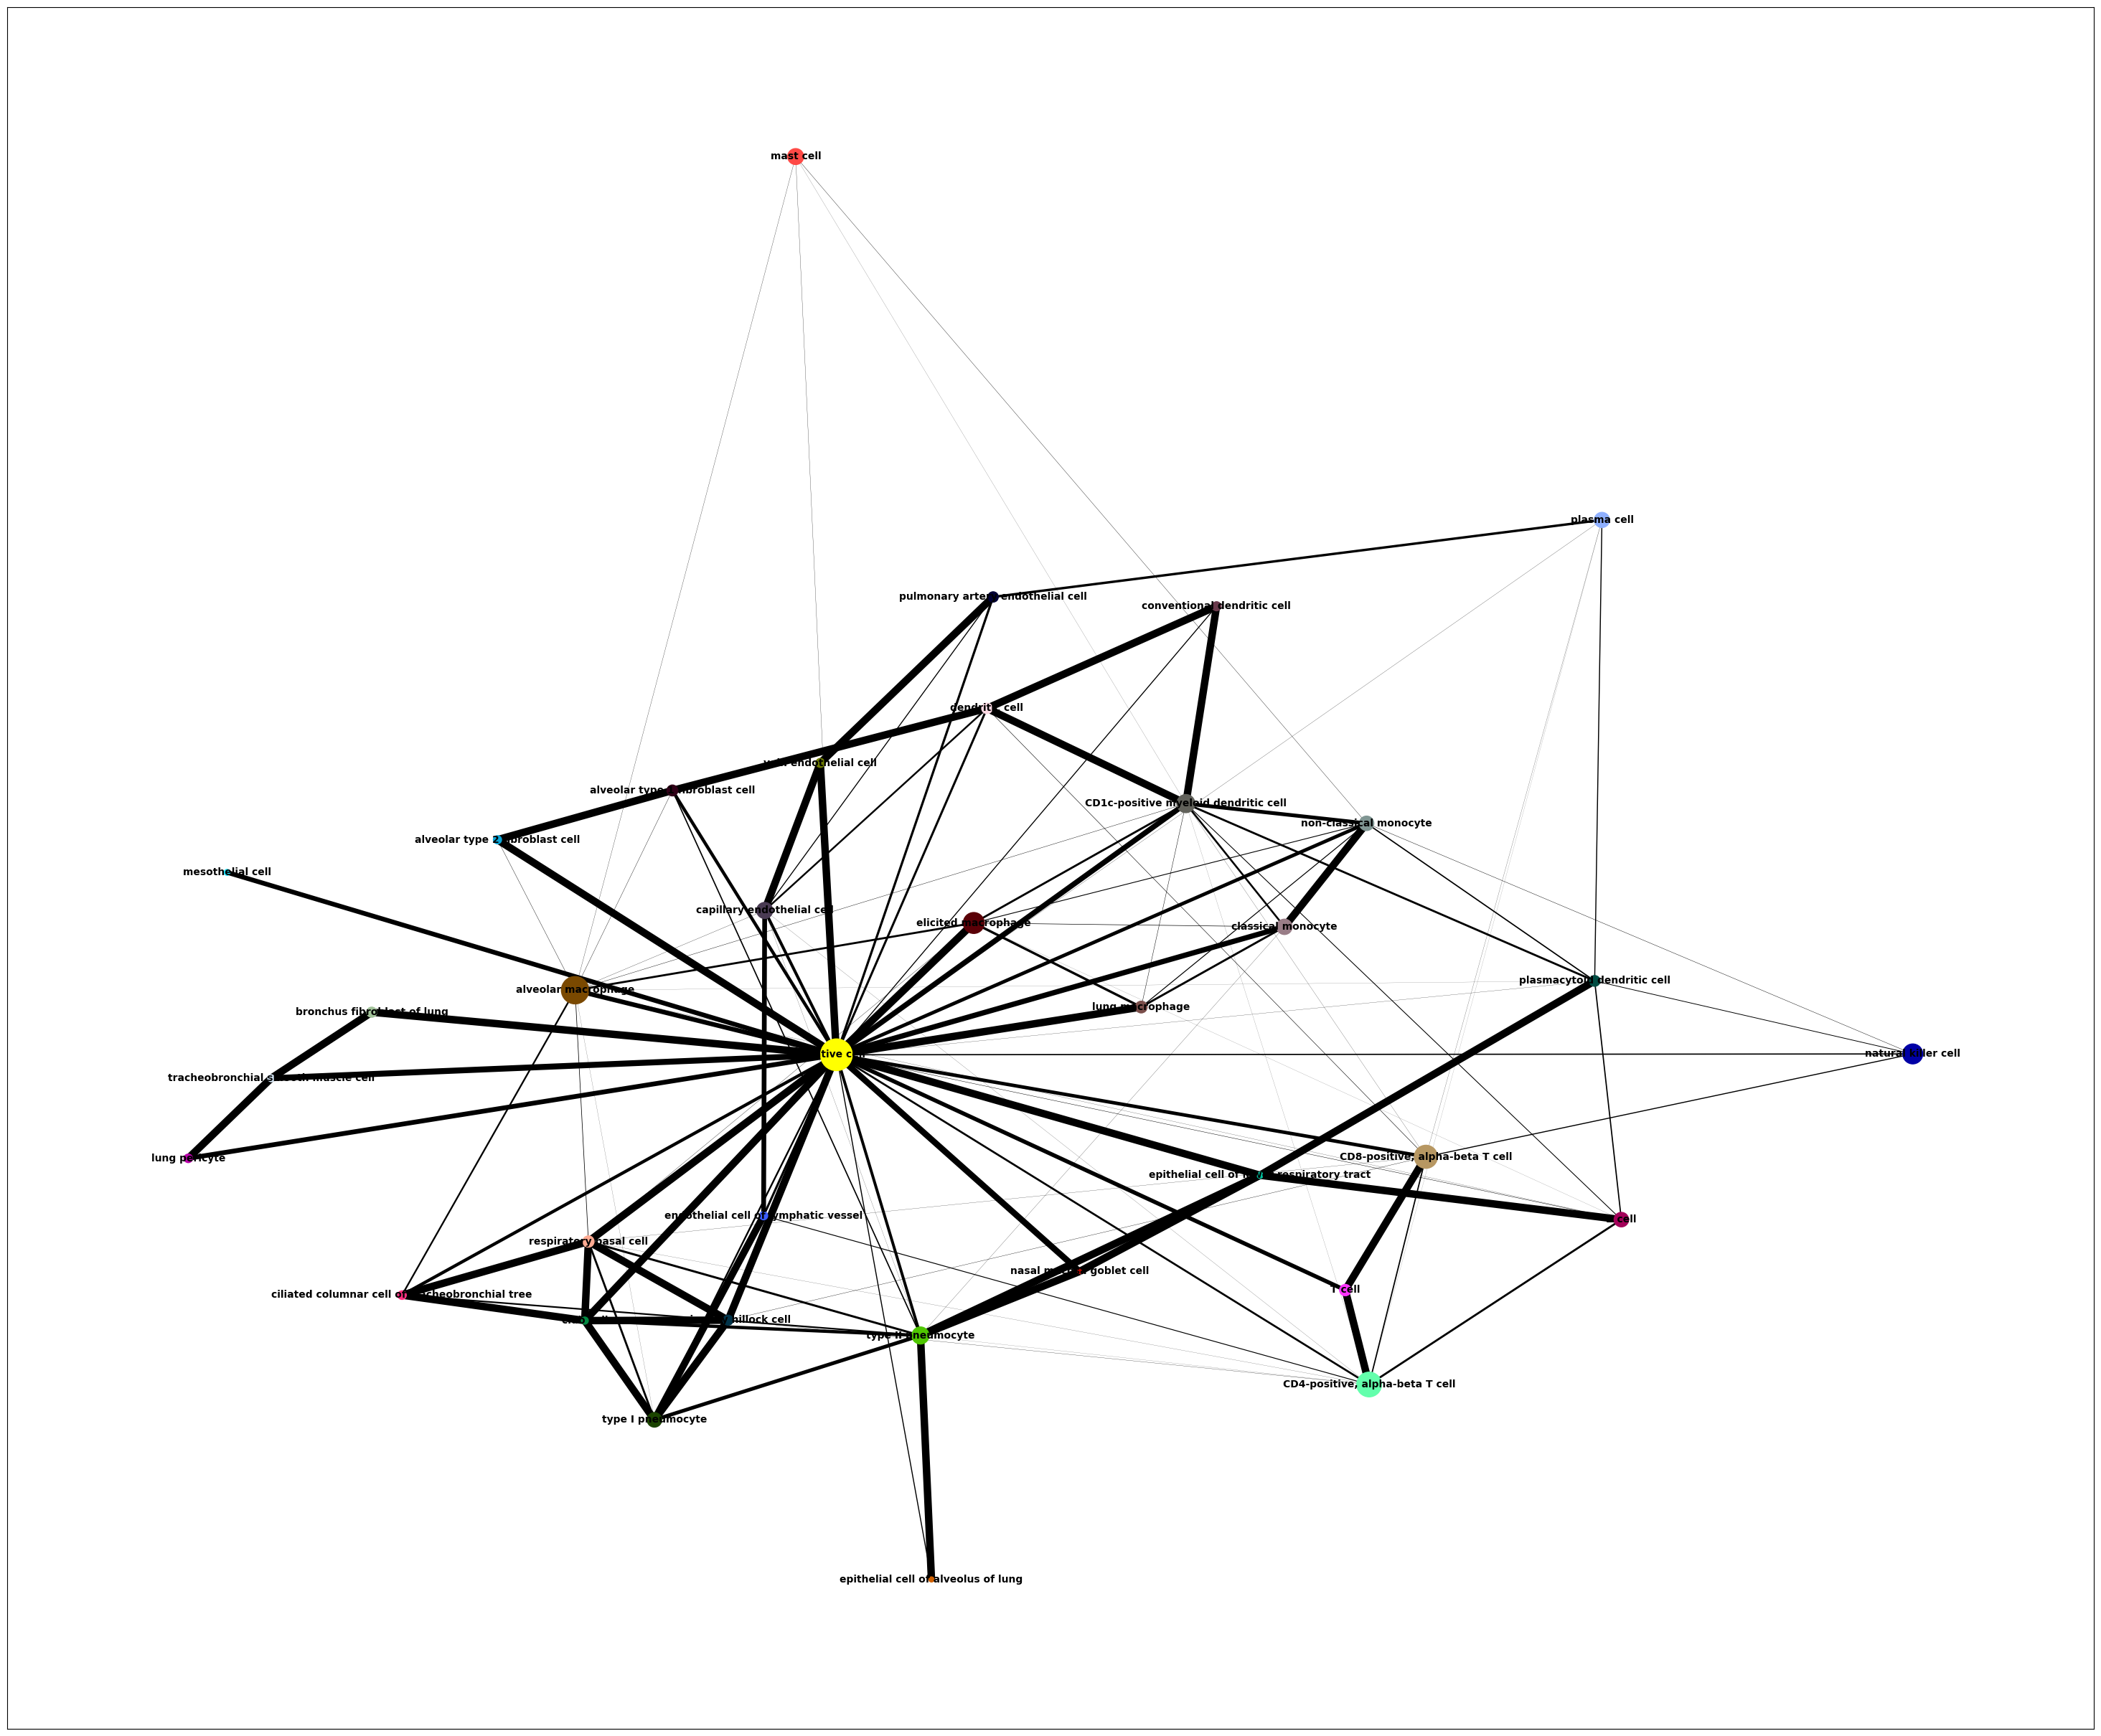

In [193]:
sc.tl.paga(sclc, groups='cell_type')

with plt.rc_context({"figure.figsize": (30, 30)}):
    sc.pl.paga(sclc, color='cell_type')

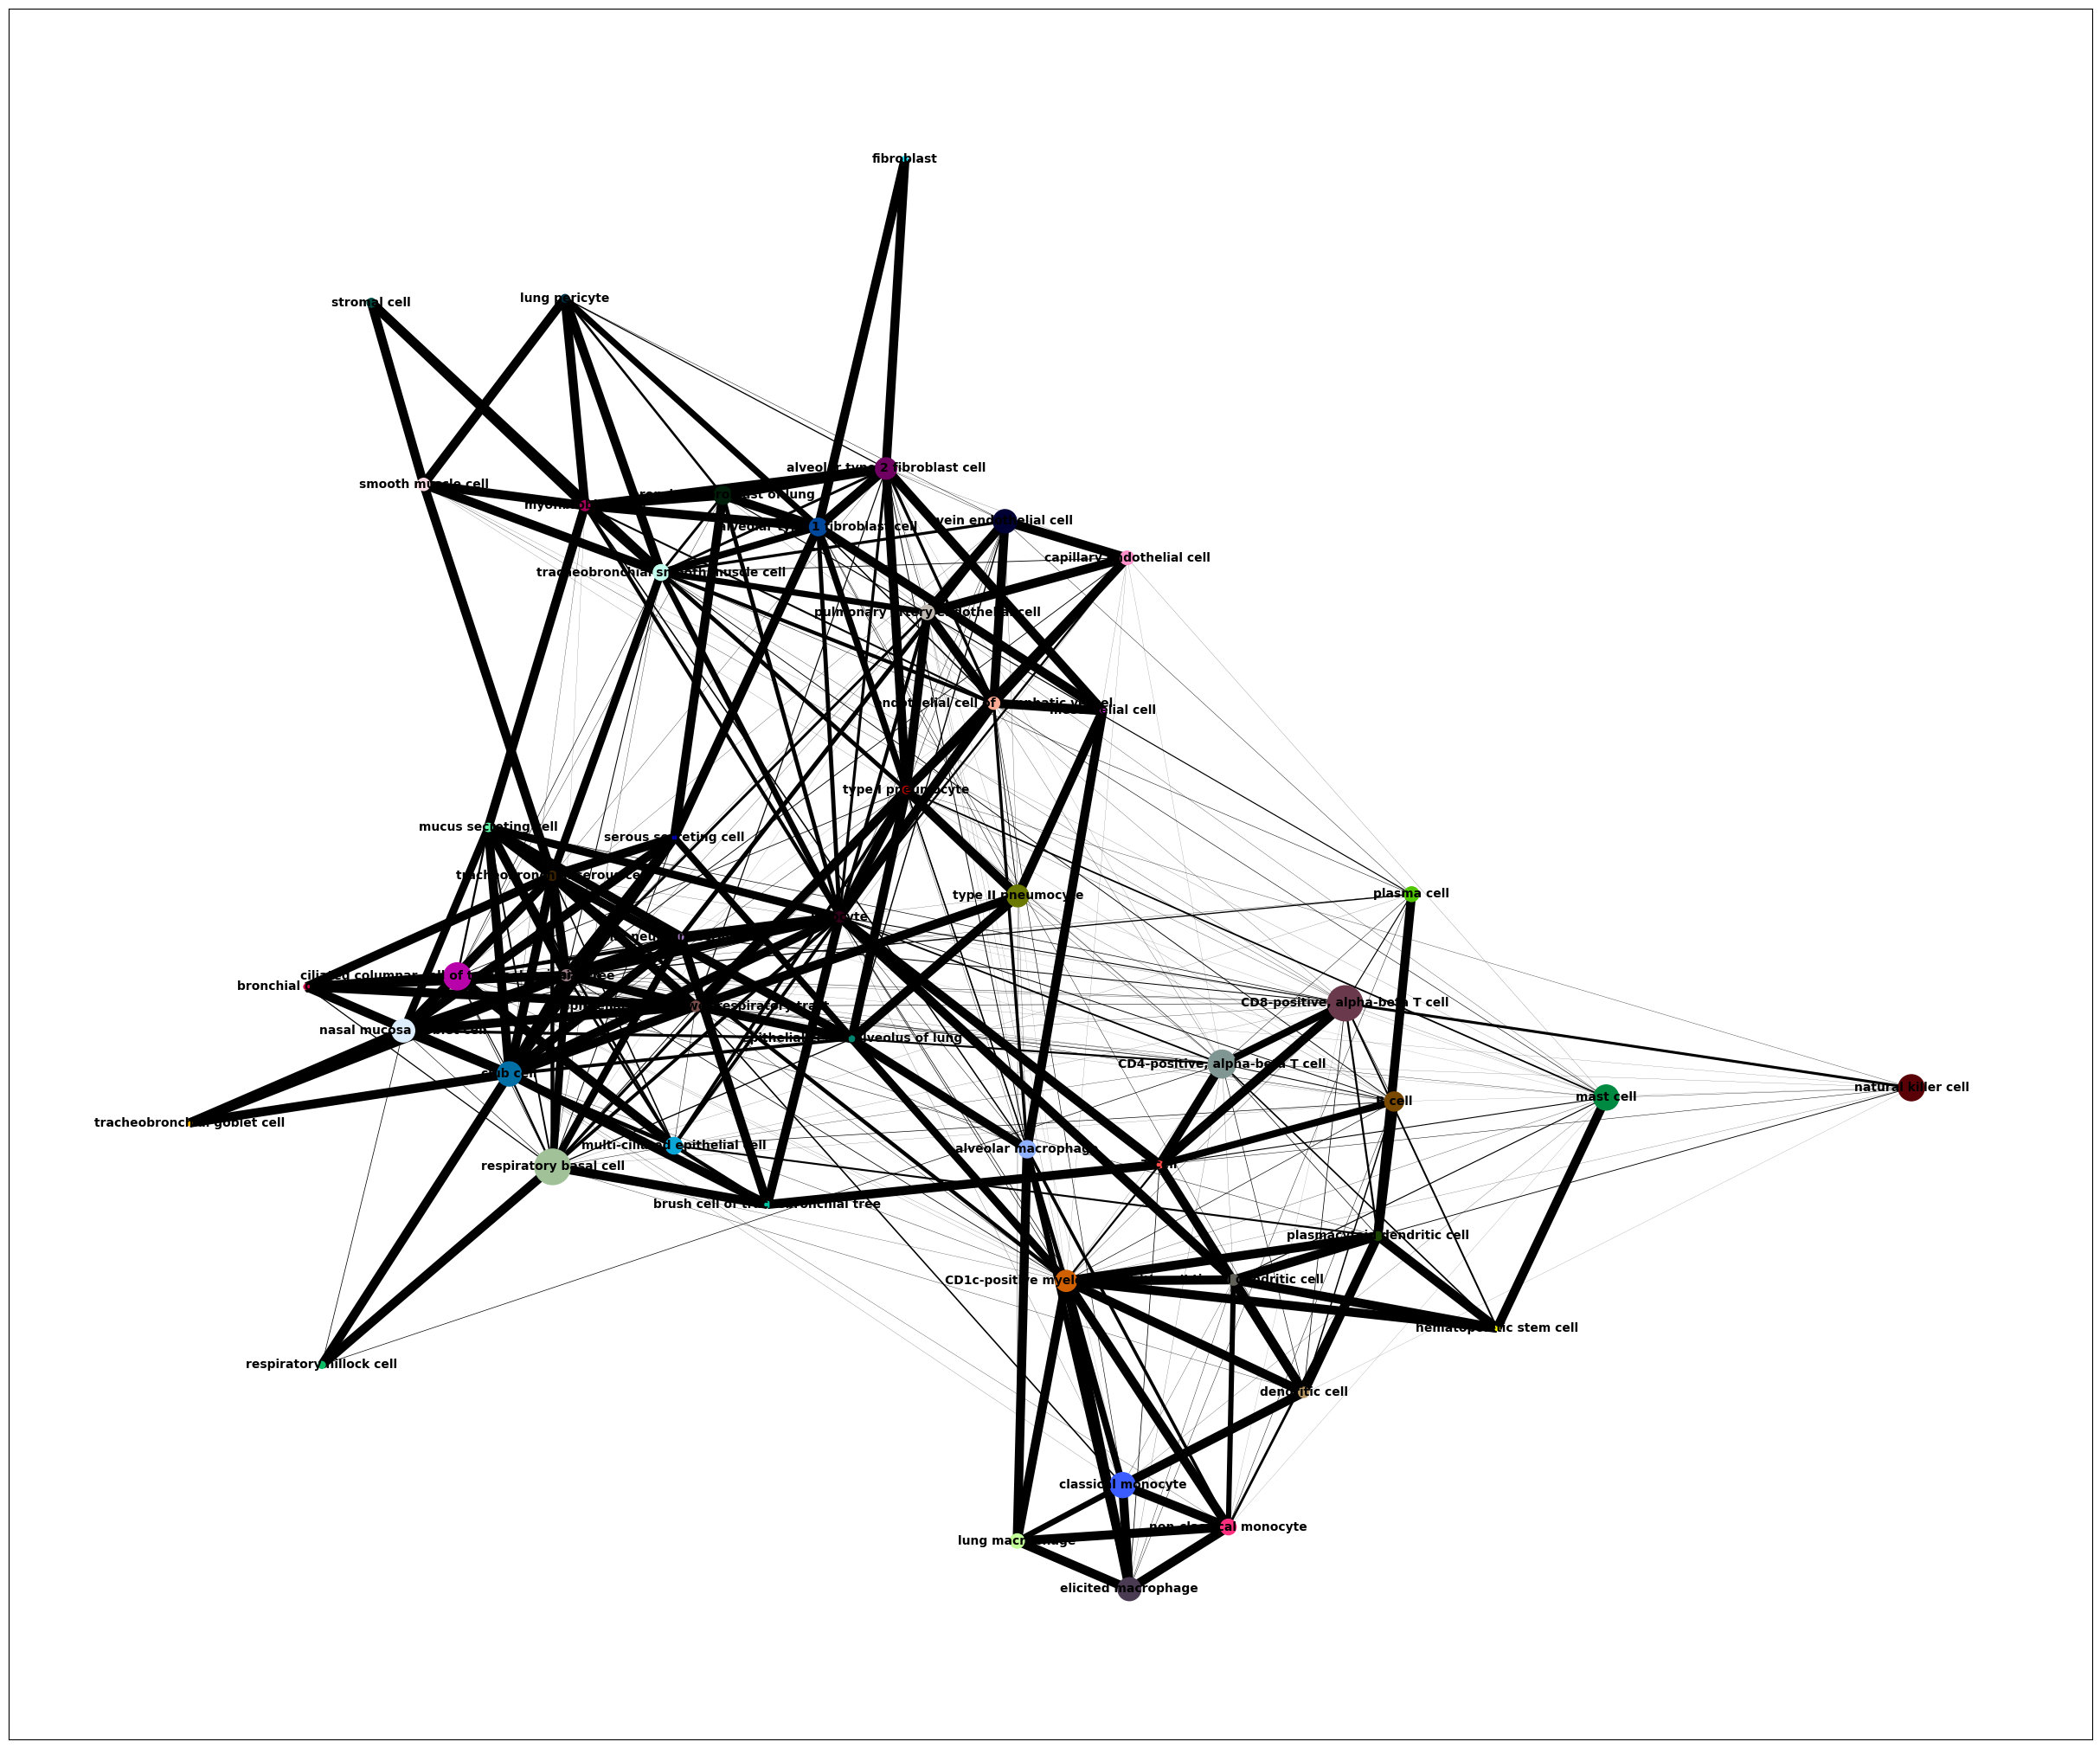

In [147]:
sc.tl.paga(control, groups='cell_type')

with plt.rc_context({"figure.figsize": (25, 25)}):
    sc.pl.paga(control, color='cell_type')

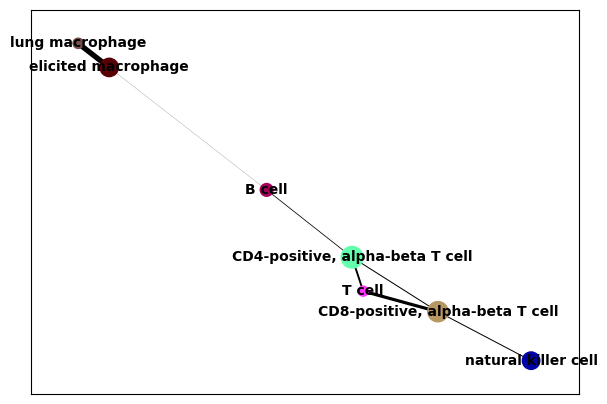

In [124]:
# Filter data for specific cell types
selected_cell_types = [
    'T cell',
    'B cell',
    'CD4-positive, alpha-beta T cell',
    'CD8-positive, alpha-beta T cell',
    'natural killer cell',
    'classical macrophage',
    'elicited macrophage',
    'lung macrophage',
]  # Add more cell types if needed
subset_sclc = sclc[sclc.obs['cell_type'].isin(selected_cell_types)]

# Run PAGA analysis
sc.pp.neighbors(subset_sclc)
sc.tl.draw_graph(subset_sclc)
sc.tl.paga(subset_sclc, groups='cell_type')

# Plot PAGA graph with manually set colors
sc.pl.paga(subset_sclc, color='cell_type')

In [123]:
# Filter data for specific cell types
selected_cell_types = [
    'T cell',
'B cell',
'CD4-positive, alpha-beta T cell',
'CD8-positive, alpha-beta T cell',
'natural killer cell',
'classical macrophage',
'elicited macrophage',
'lung macrophage',
'bronchus fibroblast of lung',
'alveolar type 1 fibroblast cell',
'alveolar type 2 fibroblast cell'
]  # Add more cell types if needed
subset_control = control[control.obs['cell_type'].isin(selected_cell_types)]

# Run PAGA analysis
sc.pp.neighbors(subset_control, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(subset_control)
sc.tl.paga(subset_control, groups='cell_type')

# Plot PAGA graph with manually set colors
sc.pl.paga(subset_control, color='cell_type')

KeyboardInterrupt: 

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [139]:
sc.tl.paga(control, groups='cell_type')

with plt.rc_context({"figure.figsize": (15, 15)}):
    sc.pl.paga(control, color='cell_type', legend_loc='right margin')

TypeError: paga() got an unexpected keyword argument 'legend_loc'

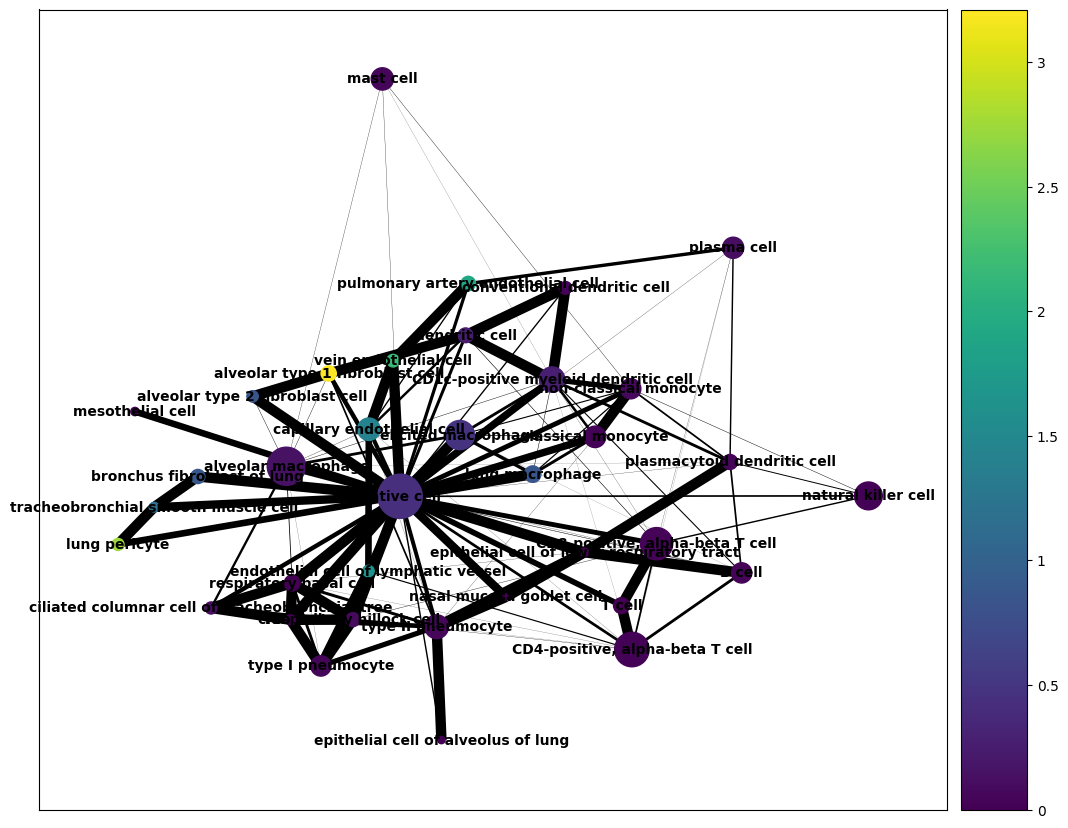

In [51]:
with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.paga(sclc, color=["A2M"])

In [167]:
%pip install diffxpy

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [168]:
import diffxpy.api as de

In [ ]:
subset = adata[adata.obs['cell type'].isin(['AT1', 'AT2'])].copy()